### installing pre requistes

In [1]:
#!pip install pandas 

In [2]:
#!pip install  polars 

In [3]:
#!pip install numpy 

In [4]:
#!pip install  matplotlib 

In [5]:
#!pip install seaborn 

In [6]:
#!pip install  pyarrow 

In [7]:
#!pip install dash 

In [8]:
#!pip install streamlit 

In [9]:
#!pip install reflex 

In [10]:
#!pip install scikit-learn

In [11]:
#pip install polars


In [12]:
#pip install matplotlib


In [13]:
#pip install seaborn

In [14]:
#pip install sklearn

In [15]:
#pip install scikit-learn


In [16]:
#pip install pyarrow


In [17]:
#!pip install fastparquet


In [18]:
#!pip install numpy>=2.0.0,<2.1.0

In [19]:
#pip install polars


### import libraries

# 1.  CNN (Convolutional Neural Network)

### step 01:data preprosessing

In [42]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import keras_tuner as kt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ✅ Fetch Stock Data
def fetch_stock_data(stock_symbol, start="2012-01-01"):
    """Fetch historical stock price data from Yahoo Finance"""
    end = datetime.datetime.today().strftime('%Y-%m-%d')
    data = yf.download(stock_symbol, start, end)
    data.dropna(inplace=True)
    return data

# ✅ Get Data
stock_symbol = "ES=F"
stock_data = fetch_stock_data(stock_symbol)




YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


### step 2: Train & Save the fine-tuned model

In [44]:
# ✅ Scale Data (Only Close Price)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(stock_data[['Close']])

# ✅ Create Training Sequences
X, Y = [], []
sequence_length = 100

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    Y.append(scaled_data[i, 0])

X, Y = np.array(X), np.array(Y)

# ✅ Train-Test Split (80-20)
split_idx = int(len(X) * 0.80)
X_train, X_test, Y_train, Y_test = X[:split_idx], X[split_idx:], Y[:split_idx], Y[split_idx:]

# ✅ Define Optimized CNN Model
def build_cnn_model(hp):
    model = Sequential()

    # ✅ CNN Layers
    model.add(Conv1D(
        filters=hp.Int('filters', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('kernel_size', values=[3, 5, 7]),
        activation='relu',
        input_shape=(sequence_length, 1)
    ))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(
        filters=hp.Int('filters_2', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('kernel_size_2', values=[3, 5]),
        activation='relu'
    ))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Flatten())

    # ✅ Fully Connected Layers
    model.add(Dense(hp.Int('dense_units', min_value=32, max_value=128, step=16), activation='relu'))
    model.add(Dropout(hp.Float('dropout_dense', min_value=0.1, max_value=0.5, step=0.1)))

    # ✅ Output Layer
    model.add(Dense(units=1))

    # ✅ Optimizer Selection
    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop', 'nadam'])
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=hp.Choice('learning_rate', values=[0.0005, 0.001, 0.005]))
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=hp.Choice('learning_rate', values=[0.0005, 0.001, 0.005]))
    elif optimizer == 'nadam':
        optimizer = Nadam(learning_rate=hp.Choice('learning_rate', values=[0.0005, 0.001, 0.005]))

    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# ✅ Hyperparameter Tuning
tuner = kt.RandomSearch(
    build_cnn_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=2,
    directory='cnn_tuning',
    project_name='stock_prediction'
)

# ✅ Start Hyperparameter Search
tuner.search(X_train, Y_train, epochs=100, validation_split=0.2)

# ✅ Get Best Model Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# ✅ Fix batch_size retrieval (Prevents KeyError)
batch_size = best_hps.values.get('batch_size', 32)

# ✅ Build & Train Best Model
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(X_train, Y_train, epochs=100, batch_size=batch_size, verbose=1)

# ✅ Save Fine-Tuned Model
best_model.save("cnn_tuned_stock.keras")

print("✅ Fine-tuned CNN model saved as 'cnn_tuned_stock.keras'")


Trial 20 Complete [00h 00m 30s]
val_loss: 0.0016874316497705877

Best val_loss So Far: 0.00035405684320721775
Total elapsed time: 00h 13m 49s
Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0101   
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0037
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016    
Epoch 9/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 
Epoch 10/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 
Epoch 11/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014     
Epoch 12/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 
Epoch 13/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

## step 3: evaluate the model

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

📊 Optimized Model Performance
➡️ Mean Absolute Error (MAE): 109.45
➡️ Mean Squared Error (MSE): 16519.86
➡️ Adjusted R² Score: 0.9700
➡️ Mean Absolute Percentage Error (MAPE): 3.03%
➡️ Explained Variance Score (EVS): 0.9851


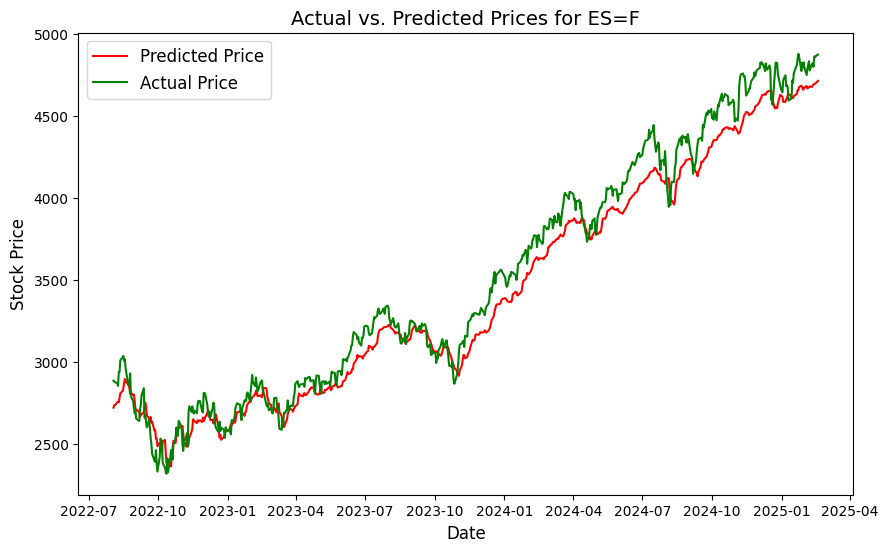

In [46]:
# ✅ Load Trained Model for Evaluation
best_model = load_model("cnn_tuned_stock.keras")

# ✅ Predict Prices
scale_factor = 1 / scaler.scale_[0]
Y_pred = best_model.predict(X_test) * scale_factor
Y_test_rescaled = Y_test * scale_factor

# ✅ Model Evaluation Metrics
mae = mean_absolute_error(Y_test_rescaled, Y_pred)
mse = mean_squared_error(Y_test_rescaled, Y_pred)
r2 = r2_score(Y_test_rescaled, Y_pred)

print(f"\n📊 Optimized Model Performance")
print(f"➡️ Mean Absolute Error (MAE): {mae:.2f}")
print(f"➡️ Mean Squared Error (MSE): {mse:.2f}")
print(f"➡️ Adjusted R² Score: {r2:.4f}")

from sklearn.metrics import mean_absolute_percentage_error, explained_variance_score

# ✅ Additional Metrics
mape = mean_absolute_percentage_error(Y_test_rescaled, Y_pred)
evs = explained_variance_score(Y_test_rescaled, Y_pred)

print(f"➡️ Mean Absolute Percentage Error (MAPE): {mape:.2%}")
print(f"➡️ Explained Variance Score (EVS): {evs:.4f}")

# ✅ Plot Actual vs. Predicted Prices
plt.figure(figsize=(10,6))
plt.plot(stock_data.index[len(stock_data) - len(Y_test):], Y_pred, 'r', label="Predicted Price")
plt.plot(stock_data.index[len(stock_data) - len(Y_test):], Y_test_rescaled, 'g', label="Actual Price")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.title(f"Actual vs. Predicted Prices for {stock_symbol}")
plt.show()


# 2. Bi-GRU (Bidirectional Gated Recurrent Unit)

### step 1: data preprocessing

In [48]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import keras_tuner as kt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Bidirectional, GRU, Dense, Dropout, Flatten, Input
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ✅ Fetch Stock Data
def fetch_stock_data(stock_symbol, start="2012-01-01"):
    """Fetch historical stock price data from Yahoo Finance"""
    end = datetime.datetime.today().strftime('%Y-%m-%d')
    data = yf.download(stock_symbol, start, end)
    data.dropna(inplace=True)
    return data

# ✅ Get Data
stock_symbol = "ES=F"
stock_data = fetch_stock_data(stock_symbol)


    

[*********************100%***********************]  1 of 1 completed


### step 2: Train & Save the fine-tuned model

In [50]:
# ✅ Scale Data (Only Close Price)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(stock_data[['Close']])

# ✅ Create Training Sequences
X, Y = [], []
sequence_length = 100  # Lookback window

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    Y.append(scaled_data[i, 0])

X, Y = np.array(X), np.array(Y)

# ✅ Train-Test Split (80-20)
split_idx = int(len(X) * 0.80)
X_train, X_test, Y_train, Y_test = X[:split_idx], X[split_idx:], Y[:split_idx], Y[split_idx:]

# ✅ Define Optimized Bi-GRU Model
def build_bi_gru_model(hp):
    model = Sequential()

    # ✅ First Bi-GRU Layer
    model.add(Bidirectional(GRU(
        units=hp.Int('units_1', min_value=32, max_value=128, step=16),
        activation='relu',
        return_sequences=True,
        input_shape=(sequence_length, 1)
    )))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))

    # ✅ Second Bi-GRU Layer
    model.add(Bidirectional(GRU(
        units=hp.Int('units_2', min_value=32, max_value=128, step=16),
        activation='relu'
    )))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))

    # ✅ Fully Connected Layers
    model.add(Flatten())  # Flattens before dense layers
    model.add(Dense(hp.Int('dense_units', min_value=32, max_value=128, step=16), activation='relu'))
    model.add(Dropout(hp.Float('dropout_dense', min_value=0.1, max_value=0.5, step=0.1)))

    # ✅ Output Layer
    model.add(Dense(units=1))

    # ✅ Optimizer Selection
    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop', 'nadam'])
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=hp.Choice('learning_rate', values=[0.0005, 0.001, 0.005]))
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=hp.Choice('learning_rate', values=[0.0005, 0.001, 0.005]))
    elif optimizer == 'nadam':
        optimizer = Nadam(learning_rate=hp.Choice('learning_rate', values=[0.0005, 0.001, 0.005]))

    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# ✅ Hyperparameter Tuning
tuner = kt.RandomSearch(
    build_bi_gru_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=2,
    directory='bi_gru_tuning',
    project_name='stock_prediction'
)

# ✅ Start Hyperparameter Search
tuner.search(X_train, Y_train, epochs=100, validation_split=0.2)

# ✅ Get Best Model Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# ✅ Fix batch_size retrieval (Prevents KeyError)
batch_size = best_hps.values.get('batch_size', 32)

# ✅ Build & Train Best Model
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(X_train, Y_train, epochs=100, batch_size=batch_size, verbose=1)

# ✅ Save Fine-Tuned Model
best_model.save("bi_gru_tuned_stock.keras")

print("✅ Fine-tuned Bi-GRU model saved as 'bi_gru_tuned_stock.keras'")


Trial 20 Complete [00h 12m 39s]
val_loss: 0.00017544434376759455

Best val_loss So Far: 0.00010467069660080597
Total elapsed time: 05h 50m 20s
Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.0234
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - loss: 0.0020
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - loss: 0.0017
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - loss: 0.0016 
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - loss: 0.0013
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - loss: 0.0012
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - loss: 0.0016
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - loss: 0.0011    
Epoch 9/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - loss: 0.0011
Epoch 10/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - loss: 9.1423e-04
Epoch 11/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - loss: 0.0010    
Epoch 12/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - loss: 8.9347e-04
Epoch 13/100
81/81 ━━━━━━━━━━━━━━

### step 3: evaluate the model

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step 

📊 Optimized Model Performance
➡️ Mean Absolute Error (MAE): 50.50
➡️ Mean Squared Error (MSE): 4148.97
➡️ Adjusted R² Score: 0.9925
➡️ Mean Absolute Percentage Error (MAPE): 1.54%
➡️ Explained Variance Score (EVS): 0.9927


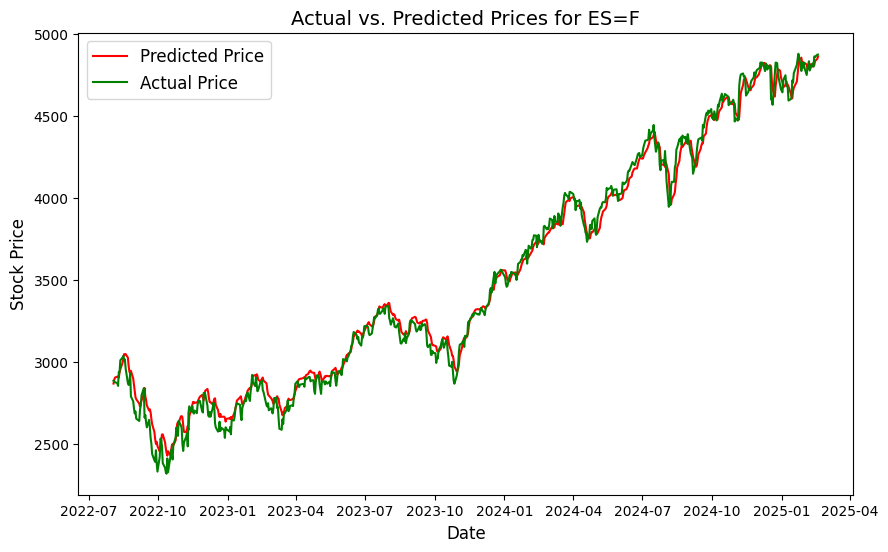

In [52]:
# ✅ Load Trained Model for Evaluation
best_model = load_model("bi_gru_tuned_stock.keras")

# ✅ Predict Prices
scale_factor = 1 / scaler.scale_[0]  # Inverse scale factor for unscaling the data
Y_pred = best_model.predict(X_test) * scale_factor
Y_test_rescaled = Y_test * scale_factor  # Reverse scaling for actual prices

# ✅ Model Evaluation Metrics
mae = mean_absolute_error(Y_test_rescaled, Y_pred)
mse = mean_squared_error(Y_test_rescaled, Y_pred)
r2 = r2_score(Y_test_rescaled, Y_pred)

print(f"\n📊 Optimized Model Performance")
print(f"➡️ Mean Absolute Error (MAE): {mae:.2f}")
print(f"➡️ Mean Squared Error (MSE): {mse:.2f}")
print(f"➡️ Adjusted R² Score: {r2:.4f}")

from sklearn.metrics import mean_absolute_percentage_error, explained_variance_score

# ✅ Additional Metrics
mape = mean_absolute_percentage_error(Y_test_rescaled, Y_pred)
evs = explained_variance_score(Y_test_rescaled, Y_pred)

print(f"➡️ Mean Absolute Percentage Error (MAPE): {mape:.2%}")
print(f"➡️ Explained Variance Score (EVS): {evs:.4f}")

# ✅ Plot Actual vs. Predicted Prices
plt.figure(figsize=(10,6))
plt.plot(stock_data.index[len(stock_data) - len(Y_test):], Y_pred, 'r', label="Predicted Price")
plt.plot(stock_data.index[len(stock_data) - len(Y_test):], Y_test_rescaled, 'g', label="Actual Price")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.title(f"Actual vs. Predicted Prices for {stock_symbol}")
plt.show()


# 3. Bi-GRU (Bidirectional Gated Recurrent Unit) with CNN (Convolutional Neural Network)

Im gonna use build hybrid model for prediction model using a hybrid approach with Bi-GRU and CNN for stock price prediction, below are step-by-step breakdown. 

### Step 1: Data Preprocessing

In [53]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import keras_tuner as kt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, GRU, Dense, Dropout, Input, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ✅ Fetch Stock Data
def fetch_stock_data(stock_symbol, start="2012-01-01"):
    """Fetch historical stock price data from Yahoo Finance"""
    end = datetime.datetime.today().strftime('%Y-%m-%d')
    data = yf.download(stock_symbol, start, end)
    data.dropna(inplace=True)
    return data

# ✅ Get Data
stock_symbol = "ES=F"  # Change this to any stock symbol
stock_data = fetch_stock_data(stock_symbol)



[*********************100%***********************]  1 of 1 completed


In [54]:
stock_data.head()
#ES=F is symbol of S&p 500 stock

Price,Close,High,Low,Open,Volume
Ticker,ES=F,ES=F,ES=F,ES=F,ES=F
Date,,,,,
2012-01-03,1272.00,1280.00,1270.25,1274.75,1565370
2012-01-04,1273.00,1274.75,1262.75,1272.00,1419339
2012-01-05,1273.00,1278.00,1259.75,1273.25,1819520
2012-01-06,1274.25,1282.25,1266.75,1273.25,1691991
2012-01-09,1275.50,1277.75,1267.25,1274.75,1438170


### Train & Save the fine-tuned model

In [55]:
# ✅ Scale Data (Only Close Price)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(stock_data[['Close']])

# ✅ Create Training Sequences
X, Y = [], []
sequence_length = 100  # Lookback window

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])  # Past 100 days
    Y.append(scaled_data[i, 0])  # Next day's closing price

X, Y = np.array(X), np.array(Y)

# ✅ Train-Test Split (80-20)
split_idx = int(len(X) * 0.80)
X_train, X_test, Y_train, Y_test = X[:split_idx], X[split_idx:], Y[:split_idx], Y[split_idx:]

# ✅ Define Hybrid CNN + Bi-GRU Model
def build_cnn_bi_gru_model(hp):
    model = Sequential()

    # ✅ CNN Layer (Feature Extraction)
    model.add(Conv1D(
        filters=hp.Int('filters', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('kernel_size', values=[3, 5, 7]),
        activation='relu',
        input_shape=(sequence_length, 1)
    ))
    model.add(MaxPooling1D(pool_size=2))

    # ✅ Bi-GRU Layers
    model.add(Bidirectional(GRU(
        units=hp.Int('units_1', min_value=32, max_value=128, step=16),
        activation='relu',
        return_sequences=True
    )))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(Bidirectional(GRU(
        units=hp.Int('units_2', min_value=32, max_value=128, step=16),
        activation='relu'
    )))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))

    # ✅ Fully Connected Layers
    model.add(Flatten())  # Flattens before dense layers
    model.add(Dense(hp.Int('dense_units', min_value=32, max_value=128, step=16), activation='relu'))
    model.add(Dropout(hp.Float('dropout_dense', min_value=0.1, max_value=0.5, step=0.1)))

    # ✅ Output Layer
    model.add(Dense(units=1))

    # ✅ Optimizer Selection
    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop', 'nadam'])
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=hp.Choice('learning_rate', values=[0.0005, 0.001, 0.005]))
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=hp.Choice('learning_rate', values=[0.0005, 0.001, 0.005]))
    elif optimizer == 'nadam':
        optimizer = Nadam(learning_rate=hp.Choice('learning_rate', values=[0.0005, 0.001, 0.005]))

    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# ✅ Hyperparameter Tuning
tuner = kt.RandomSearch(
    build_cnn_bi_gru_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=2,
    directory='cnn_bi_gru_tuning',
    project_name='stock_prediction'
)

# ✅ Start Hyperparameter Search
tuner.search(X_train, Y_train, epochs=100, validation_split=0.2)

# ✅ Get Best Model Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# ✅ Fix batch_size retrieval (Prevents KeyError)
batch_size = best_hps.values.get('batch_size', 32)  # Default batch size if missing

# ✅ Build & Train Best Model
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(X_train, Y_train, epochs=100, batch_size=batch_size, verbose=1)

# ✅ Save Fine-Tuned Model
best_model.save("cnn_bi_gru_tuned_stock.keras")

print("✅ Fine-tuned CNN + Bi-GRU model saved as 'cnn_bi_gru_tuned_stock.keras'")


Trial 20 Complete [00h 08m 32s]
val_loss: 0.00030975321715231985

Best val_loss So Far: 0.0002021685868385248
Total elapsed time: 2d 03h 26m 11s
Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0223
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0048
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0031
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0025
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0022
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0026
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0020
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0020
Epoch 9/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.0020
Epoch 10/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0030
Epoch 11/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0019
Epoch 12/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0019
Epoch 13/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/

### Evaluate Model

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step 

📊 Optimized Model Performance
➡️ Mean Absolute Error (MAE): 461.63
➡️ Mean Squared Error (MSE): 315513.23
➡️ Adjusted R² Score: 0.4277
➡️ Mean Absolute Percentage Error (MAPE): 11.85%
➡️ Explained Variance Score (EVS): 0.8087


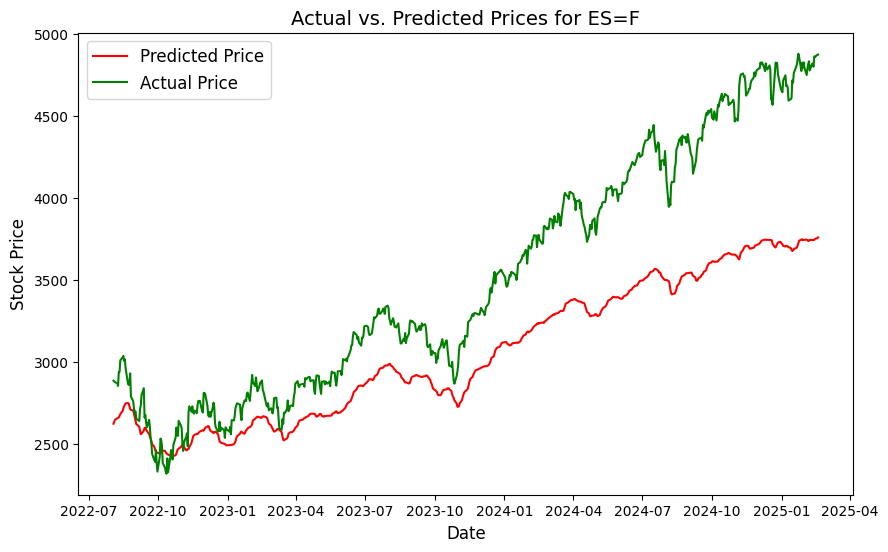

In [56]:
# ✅ Load Trained Model for Evaluation
best_model = load_model("cnn_bi_gru_tuned_stock.keras")

# ✅ Predict Prices
scale_factor = 1 / scaler.scale_[0]  # Inverse scale factor for unscaling the data
Y_pred = best_model.predict(X_test) * scale_factor
Y_test_rescaled = Y_test * scale_factor  # Reverse scaling for actual prices

# ✅ Model Evaluation Metrics
mae = mean_absolute_error(Y_test_rescaled, Y_pred)
mse = mean_squared_error(Y_test_rescaled, Y_pred)
r2 = r2_score(Y_test_rescaled, Y_pred)

# ✅ Print Results
print(f"\n📊 Optimized Model Performance")
print(f"➡️ Mean Absolute Error (MAE): {mae:.2f}")
print(f"➡️ Mean Squared Error (MSE): {mse:.2f}")
print(f"➡️ Adjusted R² Score: {r2:.4f}")

from sklearn.metrics import mean_absolute_percentage_error, explained_variance_score

# ✅ Calculate Additional Metrics
mape = mean_absolute_percentage_error(Y_test_rescaled, Y_pred)
evs = explained_variance_score(Y_test_rescaled, Y_pred)

# ✅ Print Results
print(f"➡️ Mean Absolute Percentage Error (MAPE): {mape:.2%}")
print(f"➡️ Explained Variance Score (EVS): {evs:.4f}")

# ✅ Plot Actual vs. Predicted Prices
plt.figure(figsize=(10,6))
plt.plot(stock_data.index[len(stock_data) - len(Y_test):], Y_pred, 'r', label="Predicted Price")
plt.plot(stock_data.index[len(stock_data) - len(Y_test):], Y_test_rescaled, 'g', label="Actual Price")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.title(f"Actual vs. Predicted Prices for {stock_symbol}")
plt.show()


### Comparison with all 3 models

|Model|  MAE | MSE | R²  | MAPE | EVS|
|--------|--------|--------|--------|--------|------|
|CNN   |109.45|16,519.86|0.9700|3.03%|0.9851|
|Bi-GRU    |50.50|4148.97|0.9925|1.54%|0.9927|
|CNN+Bi-GRU|461.63|315,513.23|0.4277|11.85%|0.8087|




MAE  -  	Mean Absolute Error(lower is better)           
MSE   - 	Mean Squared Error         (lower is better)             
R² 	   - Coefficient of Determination (R-Squared Score)  (higher is better)            
MAPE   	-Mean Absolute Percentage Error  (lower is better)           
EVS    	-Explained Variance Score        (higher is better)   

Bi-GRU is the best model across all key metrics. It has the lowest MAE (50.50), lowest MSE (4,148.97), highest R² (0.9925), lowest MAPE (1.54%), and highest EVS (0.9927). This means it makes the most accurate predictions and captures the stock price trends effectively.  

CNN performs decently, but it's less accurate than Bi-GRU, with higher errors (MAE: 109.45) and lower R² (0.9700). It’s still a good alternative but not as strong as Bi-GRU.   

Hybrid CNN + Bi-GRU performs the worst.  Its error metrics are significantly higher than the other two models (MAE: 461.63, MSE: 315,513.23, R²: 0.4277). This suggests that the combination of CNN and Bi-GRU might not be well-suited for your dataset.